In [123]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.gridspec as gridspec
import corner
import matplotlib.gridspec as grid
from matplotlib.backends.backend_pdf import PdfPages
from corner import corner
sns.set_style("ticks")

sns.set_context("paper", font_scale=0.7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
outdir = '/Users/christof/dstrf/output/'

In [124]:
os.chdir('/Users/christof/dstrf')

In [125]:
phasic_4 = np.load("resultsMCMC_4_22_23/old/phasic_4_mcmc.npz")
phasic_22 = np.load("resultsMCMC_4_22_23/old/phasic_22_mcmc.npz")
phasic_23 = np.load("resultsMCMC_4_22_23/old/phasic_23_mcmc.npz")
phasics = [phasic_4,phasic_22,phasic_23]

tonic_4 = np.load("resultsMCMC_4_22_23/old/tonic_4_mcmc.npz")
tonic_22 = np.load("resultsMCMC_4_22_23/old/tonic_22_mcmc.npz")
tonic_23 = np.load("resultsMCMC_4_22_23/old/tonic_23_mcmc.npz")
tonics = [tonic_4,tonic_22,tonic_23]

m = [phasics,tonics]
r = [(4,12),(-1,40),(-.8,.4)]

In [126]:
def rf_corner(m,r):
    for i in np.arange(0,3):
        est_clr = ["darkcyan","goldenrod"]
        matlabs = ['$\omega$',r"$\alpha_1$",r"$\alpha_2$"]
        ranges = r
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
        for data, row in [(m[0][i], 0), (m[1][i], 1)]:
            c = corner(data["samples"][:, :3],
                       labels=matlabs,
                       fig=fig,
                       range=ranges,
                       color=est_clr[row],
                       bins=50, 
                       smooth=1.5,
                       smooth1d=0
                      )
        for ax in fig.get_axes():
              ax.tick_params(axis='both', which='major', labelsize=4)
        fig.legend(("Phasic","Tonic"), framealpha = 0,loc="upper right")

        for ax in axes.flat:
            ax.tick_params(labelrotation=0)
        plt.savefig(os.path.join(outdir, "{0}_posterior_RFs.pdf".format(i)))

        fig.set_figwidth(7)
        fig.set_figheight(7)
        plt.show()        
        plt.close()

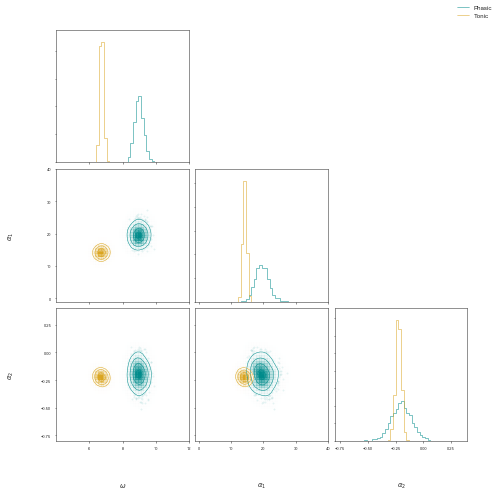

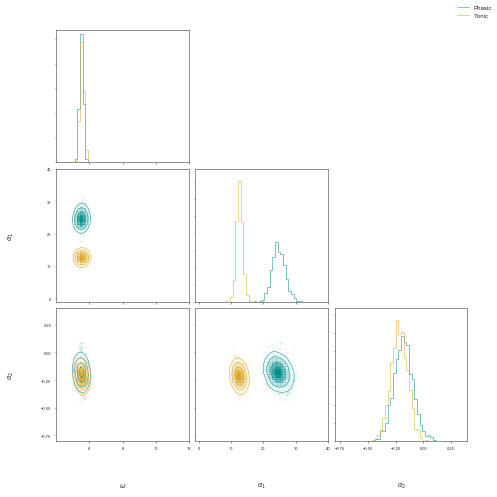

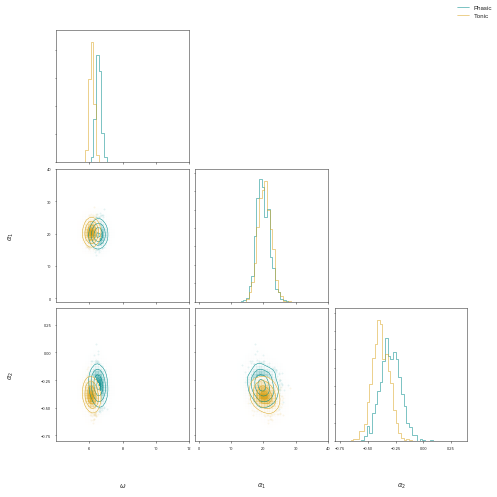

In [127]:
rf_corner(m,r)

In [42]:
def model_corner(m,r):
    for i in np.arange(0,2):
        est_clr = ["darkred","darkmagenta","chocolate"]
        matlabs = ['$\omega$',r"$\alpha_1$",r"$\alpha_2$"]
        ranges = r
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))
        for data, row in [(m[i][0], 2), (m[i][1], 1),(m[i][2],0)]:
            c = corner(data["samples"][:, :3],
                       labels=matlabs,
                       fig=fig,
                       range=ranges,
                       color=est_clr[row],
                       bins=50, 
                       smooth=1.5,
                       smooth1d=0
                      )
        for ax in fig.get_axes():
              ax.tick_params(axis='both', which='major', labelsize=4)
        fig.legend(("RF4","RF22","RF23"), framealpha = 0,loc="upper right")


        for ax in axes.flat:
            ax.tick_params(labelrotation=0)
        plt.savefig(os.path.join(outdir, "{0}_posterior_models.pdf".format(i)))
        fig.set_figwidth(7)
        fig.set_figheight(7)
        plt.show()



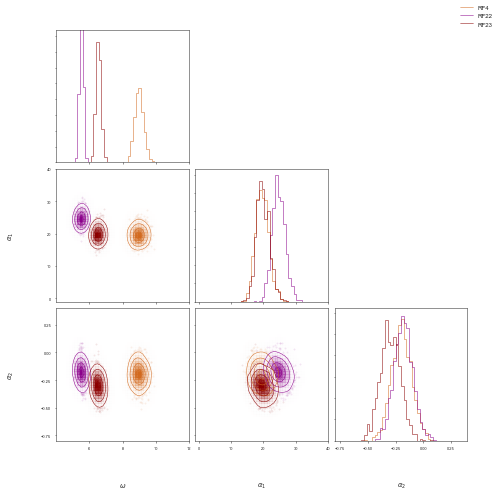

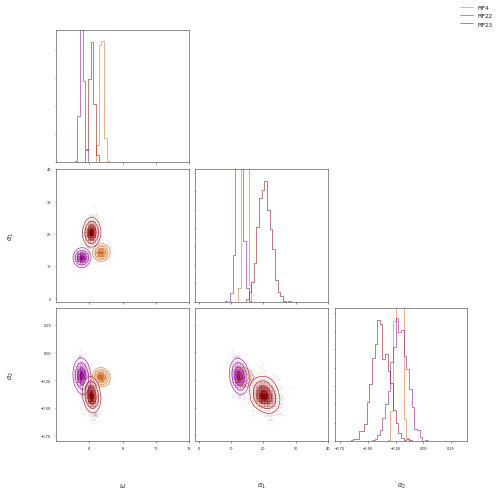

In [43]:
model_corner(m,r)

In [112]:
from munch import Munch
from dstrf import spikes, strf, simulate
import matplotlib.gridspec as grid
import seaborn as sns

(1000, 3000)

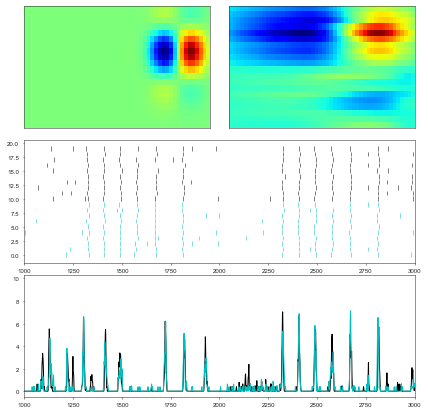

In [117]:
args = "config/song_dynamical.yml"
with open(args, "rt") as fp:
    cf = Munch.fromYAML(fp) #config file, song_dynamical.yml
    
rf_type = cf.data.filter.rf
if(rf_type == 4):
    est_clr = "darkred"
elif(rf_type ==22):
    est_clr = "darkmagenta"
else:
    est_clr = "chocolate"
plt.figure(figsize = (7,7))
g = grid.GridSpec(3,2,height_ratios=[1,1,1], wspace = 0.1, hspace = 0.1, top = 0.9)
# Filter stuff
ncos = cf.model.filter.ncos
kcosbas = strf.cosbasis(cf.model.filter.len, ncos)
krank = cf.model.filter.get("rank", None)

k1, k1t, k1f = simulate.get_filter(cf)



#######
predfile = phasic_22
est = predfile["mle"]
estparams = est[:3]

model_info = cf.data.dynamics.model
model_type = model_info[model_info.find('/') + 1:]
model_type = model_type[:model_type.find('.yml')]

rf_type = cf.data.filter.rf
rf_mle = strf.from_basis(strf.defactorize(est[3:], cf.data.filter.nfreq, krank), kcosbas)


#Input and Estimaed RFs
axes = plt.subplot(g[0,0])
plt.imshow(k1,extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]),cmap='jet',aspect='auto')
plt.xticks([])
plt.yticks([])
    

axes = plt.subplot(g[0,1])
plt.imshow(rf_mle,extent=(k1t[0], k1t[-1], k1f[0], k1f[-1]), cmap='jet', aspect='auto')
plt.xticks([])
plt.yticks([])

#Dan file stuff
data = np.load(os.path.join(base_dir, "phasic_22_pred.npz"))
V = data["V"]
stim = data["stim"].squeeze()
tspk = data["spike_v"]
pspk = data["pspike_v"]
ntrials = min(tspk.shape[1], 10)

upsample = int(cf.data.dt / cf.model.dt)
test_psth = spikes.psth(tspk, upsample, 1)
pred_psth = spikes.psth(pspk, upsample, 1)
t_psth = np.linspace(0, data["duration"], test_psth.size)

#Raster
axes = plt.subplot(g[1,:])
# axes 2: rasters
for i in range(ntrials):
    spk_t = np.nonzero(tspk[:, i])[0] * cf.model.dt - 1000
    plt.vlines(spk_t, i - 0.4 + ntrials, i + 0.4 + ntrials)
for i in range(ntrials):
    spk_t = np.nonzero(pspk[:, i])[0] * cf.model.dt - 1000
    plt.vlines(spk_t, i - 0.4, i + 0.4, color=est_clr[0])

axes.set_xlim(1000, 3000);


# PSTHs
axes = plt.subplot(g[2,:])
plt.plot(t_psth, test_psth, linewidth=1, color='k', label="data")
plt.plot(t_psth, pred_psth, linewidth=1, color=est_clr[0], label="data")
axes.set_xlim(1000,3000)


#plt.savefig(os.path.join(outdir, "univariate_{}_example.pdf".format(name)))

In [119]:
data = np.load('/Users/christof/dstrf/resultsMCMC_4_22_23/phasic_4_pred.npz')
data.allow_pickle=True
keys = np.array(list(data.keys()))
keys

array(['stim_dt', 'spike_dt', 'ntrials', 'stim', 'spike_v', 'spike_t',
       'spike_h', 'duration', 'V', 'I', 'tspike_psth', 'pspike_v',
       'pspike_psth', 'tspike_corr', 'pspike_corr'], dtype='<U11')

In [120]:
data = np.load('/Users/christof/dstrf/resultsMCMC_4_22_23/old/phasic_4_mcmc.npz')
data.allow_pickle=True
keys = np.array(list(data.keys()))
keys

array(['mle', 'reg_alpha', 'reg_lambda', 'chain', 'samples', 'prob',
       'step', 'stim', 'spike_v', 'spike_h', 'duration', 'kernel'],
      dtype='<U10')

In [121]:
data = np.load('/Users/christof/dstrf/results/phasic_4_samples.npz')
data.allow_pickle=True
keys = np.array(list(data.keys()))
keys

array(['spike_v', 'samples', 'reg_lambda', 'prob', 'spike_h', 'stim',
       'reg_alpha', 'duration', 'mle', 'kernel'], dtype='<U10')

In [122]:
data = np.load('/Users/christof/dstrf/results/phasic_4_predict.npz')
data.allow_pickle=True
keys = np.array(list(data.keys()))
keys

array(['spike_v', 'duration', 'spike_h', 'stim_dt', 'spike_dt', 'stim',
       'V', 'ntrials', 'spike_t', 'pred spikes', 'sim psth', 'pred psth',
       'estimates', 'Vpred', 'eo cc', 'pred cc', 'total samples',
       'valid samples'], dtype='<U13')

In [99]:
keys

array(['mle', 'reg_alpha', 'reg_lambda', 'chain', 'samples', 'prob',
       'step', 'stim', 'spike_v', 'spike_h', 'duration', 'kernel'],
      dtype='<U10')

In [100]:
data = np.load("results/phasic_22_predict.npz")
data.allow_pickle=True
keys = np.array(list(phasic_4.keys()))
keys

array(['mle', 'reg_alpha', 'reg_lambda', 'chain', 'samples', 'prob',
       'step', 'stim', 'spike_v', 'spike_h', 'duration', 'kernel'],
      dtype='<U10')